In [1]:
import qiskit
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from qiskit.providers.aer import AerSimulator

In [152]:
def simons_oracle(n, b):
    # We need to make a QuantumCircuit object to return
    # This circuit has 2*n qubits: n input qubits,
    
    simons_circ = QuantumCircuit(n*2)
    
    # reverse b string to fit qiskit's qubit ordering
    b=b[::-1]
    
    #finding the index of the first entry in the secret bit string that is 1
    qubit1_index =0
    for i in range(n):
        if b[i] == '1':
            qubit1_index = i
            break
    
    # copying the data of first register to second register
    for i in range(n):
        simons_circ.cx(i, n+i)
        
    #applying bit wise X-OR from register 1 to register 2 
    #where qubits of first register is 1
    for i in range(n):
        if b[i] == '1':
            simons_circ.cx(qubit1_index,n+i)
            
    #convert oracle to gates 
    circ = simons_circ.to_gate()
    circ.name = "Simons Oracle"
    
    #reverse secret bitstring to return 
    b=b[::-1]
    return circ,b 




In [153]:
def simons_algorithm(oracle,n):
    # add n qubits for a the second register
    simons_circ = QuantumCircuit(n*2, n)
    
    # applying H-gate on qubits of first register
    for qubit in range(n):
        simons_circ.h(qubit)
    
    # Let's append the oracle gate to our circuit:
    simons_circ.append(oracle[0], range(2*n))
    
    # applying again H-gate on qubits of first register
    for qubit in range(n):
        simons_circ.h(qubit)
    
    #measure qubits of first register
    for i in range(n):
        simons_circ.measure(i, i)
    
    return simons_circ

In [162]:
n=2
oracle_gate = simons_oracle(n,'1100')
simons_circuit = simons_algorithm(oracle_gate, n)
simons_circuit.draw()

┌───┐┌────────────────┐┌───┐┌─┐   
q_0: ┤ H ├┤0               ├┤ H ├┤M├───
     ├───┤│                │├───┤└╥┘┌─┐
q_1: ┤ H ├┤1               ├┤ H ├─╫─┤M├
     └───┘│  Simons Oracle │└───┘ ║ └╥┘
q_2: ─────┤2               ├──────╫──╫─
          │                │      ║  ║ 
q_3: ─────┤3               ├──────╫──╫─
          └────────────────┘      ║  ║ 
c_0: ═════════════════════════════╩══╬═
                                     ║ 
c_1: ════════════════════════════════╩═

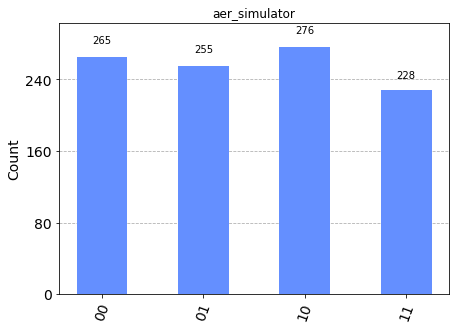

In [163]:
#simulate the case of 4 input qubits on the noisless simulator
#then simulate on 2 different quantum computers with noise 

#noisless simulations

simulator = Aer.get_backend('aer_simulator_stabilizer')
circ = transpile(simons_circuit, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)

plot_histogram(counts, title="aer_simulator")

In [167]:
def bdotz(b, z):
    k = 0
    for i in range(len(b)):
        k += int(b[i]) * int(z[i])
    return (k % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(oracle_gate[1], z, bdotz(oracle_gate[1],z)) )

IndexError: string index out of range

/var/folders/05/9y6gplnj7kg_9m62mlq2tlqr0000gn/T/ipykernel_22670/2955900077.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo,FakeCasablanca


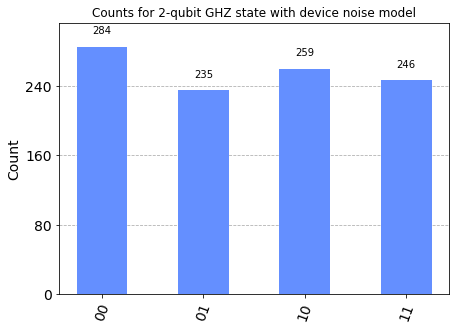

In [168]:
#use of noisy simulator
from qiskit.test.mock import FakeVigo,FakeCasablanca
device_backend = FakeVigo()

# Transpile the circuit for the noisy basis gates
sim_vigo = AerSimulator.from_backend(device_backend)
tcirc = transpile(simons_circuit, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 2-qubit GHZ state with device noise model")



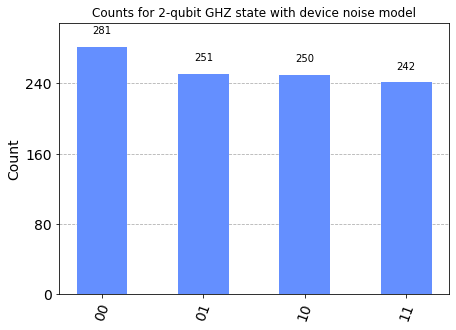

In [169]:
device_backend = FakeCasablanca()

# Transpile the circuit for the noisy basis gates
sim_casa = AerSimulator.from_backend(device_backend)
tcirc = transpile(simons_circuit, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_casa.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 2-qubit GHZ state with device noise model")


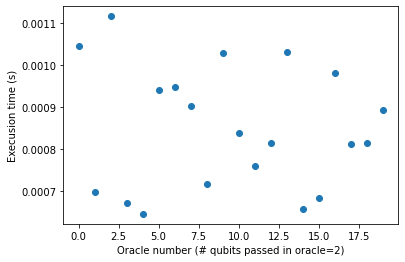

In [218]:
import time
import matplotlib.pyplot as plt
time_for_diff_oracles=[]
for i in range(20):
    start_time = time.time()
    n=2
    b = np.random.randint(1,2**n)
    b_str = format(b, '0'+str(n)+'b')
    oracle_gate = simons_oracle(n,b_str)
    simons_circuit = simons_algorithm(oracle_gate, n)
    time_for_diff_oracles.append(time.time()-start_time)
    
plt.plot(range(20),time_for_diff_oracles,"o")
plt.xlabel("Oracle number (# qubits passed in oracle=2)")
plt.ylabel("Execusion time (s)")
plt.savefig("oracle_execusion_simons.pdf")
plt.show()
    


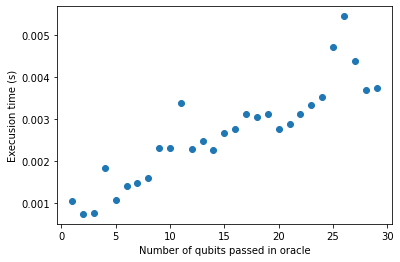

In [210]:
time_for_diff_n=[]
for i in np.arange(1,30,1):
    start_time = time.time()
    n=i
    b = np.random.randint(1,2**n)
    b_str = format(b, '0'+str(n)+'b')
    oracle_gate = simons_oracle(n,b_str)
    simons_circuit = simons_algorithm(oracle_gate, n)
    time_for_diff_n.append(time.time()-start_time)
    
plt.plot(np.arange(1,30,1),time_for_diff_n,"o")
plt.xlabel("Number of qubits passed in oracle")
plt.ylabel("Execusion time (s)") 
plt.savefig("n_qubit_execusion_simons.pdf")
plt.show()